In [1]:
%load_ext autoreload
%autoreload 2
import sys
import torch
import math
import numpy as np
from torch import nn
sys.path.append('..')
from pathlib import Path
from typing import Union
from erank.data import get_metadataset_class
from omegaconf import OmegaConf
from torch.utils import data
from erank.utils import load_directions_matrix_from_task_sweep
import matplotlib.pyplot as plt
from erank.data.omniglotdataset import OmniglotDataset
from ml_utilities.data_utils import show_images, Normalizer
gpu_id = 0

/home/max/anaconda3/envs/erank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Specify dataset directory etc.

In [2]:
data_dir = '/home/max/phd/data'
dataset_name = 'omniglot'
top_level_folders = [
    'images_background',  # original train data 
    'images_evaluation',  # original test data
]
dataset_split_toplevel_folders = {
    'train': 'images_background',
    'val': 'images_background',
    'test': 'images_evaluation'
}

## Check file directory

In [3]:
# check folders
dataset_dir = Path(data_dir) / dataset_name
toplevel_folders_disk = [d.stem for d in dataset_dir.iterdir() if d.is_dir()]
set(top_level_folders).issubset(set(toplevel_folders_disk))

True

In [4]:
# check num alphabets
background_alphabets = [a.stem for a in (dataset_dir/ 'images_background').iterdir()]
evaluation_alphabets = [a.stem for a in (dataset_dir/ 'images_evaluation').iterdir()]
len(background_alphabets), len(evaluation_alphabets)

(30, 20)

## Dataset initialization + data loading

In [5]:
ogds = OmniglotDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       dataset_layout='metadataset',
                       seed=0)

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:04<00:00,  5.44it/s]


In [6]:
# number of classes
classes = list(ogds._data.keys())
len(classes)

883

In [7]:
# shape of data stored in dataset
imgs = ogds._data[classes[0]]
imgs.shape

(20, 1, 28, 28)

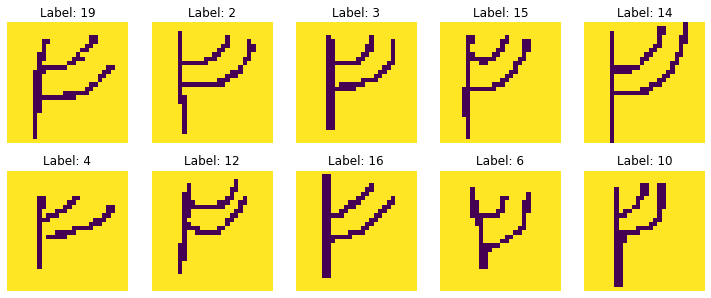

In [8]:
show_images(imgs, num_images=10, n_cols=5)

## Task generation

In [9]:
ogds.create_pregen_tasks()
for t in ogds.pregen_tasks:
    print(t.name)

Anglo-Saxon_Futhorc--character05#Bengali--character28#Greek--character05#Latin--character16#Malay_(Jawi_-_Arabic)--character07
Arcadian--character25#Armenian--character32#Hebrew--character03#N_Ko--character10#N_Ko--character20
Asomtavruli_(Georgian)--character27#Braille--character22#Japanese_(katakana)--character32#Korean--character20#Malay_(Jawi_-_Arabic)--character19
Bengali--character09#Grantha--character42#Korean--character11#Korean--character19#Mkhedruli_(Georgian)--character16
Braille--character12#Grantha--character31#Japanese_(katakana)--character32#Syriac_(Estrangelo)--character01#Syriac_(Estrangelo)--character04


In [10]:
# different seed -> must sample other tasks, same seed -> same tasks OK
ogds1 = OmniglotDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       dataset_layout='metadataset',
                       seed=0)

ogds1.create_pregen_tasks()
for t in ogds1.pregen_tasks:
    print(t.name)

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:04<00:00,  5.47it/s]
Anglo-Saxon_Futhorc--character05#Bengali--character28#Greek--character05#Latin--character16#Malay_(Jawi_-_Arabic)--character07
Arcadian--character25#Armenian--character32#Hebrew--character03#N_Ko--character10#N_Ko--character20
Asomtavruli_(Georgian)--character27#Braille--character22#Japanese_(katakana)--character32#Korean--character20#Malay_(Jawi_-_Arabic)--character19
Bengali--character09#Grantha--character42#Korean--character11#Korean--character19#Mkhedruli_(Georgian)--character16
Braille--character12#Grantha--character31#Japanese_(katakana)--character32#Syriac_(Estrangelo)--character01#Syriac_(Estrangelo)--character04


In [11]:
ogds.get_tasks(num_tasks=1)[0].name, ogds1.get_tasks(num_tasks=1)[0].name

('Anglo-Saxon_Futhorc--character05#Bengali--character28#Greek--character05#Latin--character16#Malay_(Jawi_-_Arabic)--character07',
 'Anglo-Saxon_Futhorc--character05#Bengali--character28#Greek--character05#Latin--character16#Malay_(Jawi_-_Arabic)--character07')

## Task support and query set sampling

In [12]:
ogds = OmniglotDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       dataset_layout='metadataset',
                       regenerate_task_support_set=True,
                       regenerate_task_query_set=False,
                       seed=0)
for task in ogds.get_tasks(num_tasks=5):
    print(task.name, len(task.support_set))

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:04<00:00,  5.38it/s]
Arcadian--character05#Bengali--character19#Grantha--character07#Mkhedruli_(Georgian)--character03#Mkhedruli_(Georgian)--character06 2
Arcadian--character18#Bengali--character02#Bengali--character28#Gujarati--character28#Latin--character08 2
Armenian--character03#Cyrillic--character05#Grantha--character12#Korean--character04#Latin--character01 2
Asomtavruli_(Georgian)--character38#Bengali--character06#Early_Aramaic--character01#Greek--character05#Japanese_(katakana)--character33 2
Cyrillic--character28#Futurama--character08#Latin--character13#Syriac_(Estrangelo)--character14#Tifinagh--character53 2


In [13]:
task = ogds.get_tasks(num_tasks=1)[0]
task.name, len(task.support_set)

('Arcadian--character05#Bengali--character19#Grantha--character07#Mkhedruli_(Georgian)--character03#Mkhedruli_(Georgian)--character06',
 2)

In [14]:
x_, y_ = task.support_set
x_.shape, y_.shape

(torch.Size([25, 1, 28, 28]), torch.Size([25, 1]))

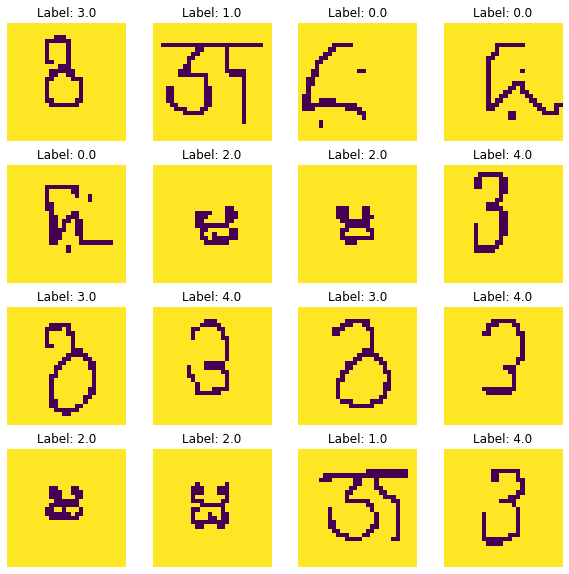

In [15]:
show_images((x_, y_), num_images=16)

In [16]:
task._support_idxes[task.task_classes[0]], task._query_idxes[task.task_classes[0]]

(array([19, 18, 13,  6,  4]), array([ 9,  5, 12,  8,  0, 15, 17,  3, 16, 11]))

In [17]:
for t_cls in task.task_classes:
    supp_idxes = task._support_idxes[t_cls]
    query_idxes = task._query_idxes[t_cls]
    intersect = np.intersect1d(supp_idxes, query_idxes)
    print(intersect)
    # assert len(intersect) == 0

[]
[]
[]
[]
[]


## Dataset Normalization

In [18]:
ogds = OmniglotDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       dataset_layout='metadataset',
                       regenerate_task_support_set=True,
                       regenerate_task_query_set=False,
                       seed=0, 
                       normalizer=None)
normalizer_values = ogds.compute_normalizer()
normalizer_values

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:04<00:00,  5.29it/s]


{'mean': [0.9213101208773438],
 'std': [0.2628733349463854],
 'num_dataset_samples': 17660}

In [19]:
tasks = ogds.sample_tasks(num_tasks=1)

In [20]:
task = tasks[0]
support_x = task.support_set[0]
task.name, support_x.shape, task.support_set[1].shape

('Anglo-Saxon_Futhorc--character05#Bengali--character28#Greek--character05#Latin--character16#Malay_(Jawi_-_Arabic)--character07',
 torch.Size([25, 1, 28, 28]),
 torch.Size([25, 1]))

In [21]:
normalizer = Normalizer(scaler_values=normalizer_values)
normalizer(support_x).shape

torch.Size([25, 1, 28, 28])

In [22]:
s = torch.randn(size=(5,1,28,28))
normalizer(s).shape

torch.Size([5, 1, 28, 28])

In [23]:
ogds2 = OmniglotDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       dataset_layout='metadataset',
                       regenerate_task_support_set=True,
                       regenerate_task_query_set=False,
                       seed=0)
tasks = ogds2.sample_tasks(num_tasks=10000)

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:04<00:00,  5.35it/s]


In [24]:
ogds2.normalizer

Normalizer(mean=[0.9213101208773438], std=[0.2628733349463854])

In [25]:
# calculate mean and std of task support sets
# should have mean 0 and std 1
mean = 0. 
std = 0.
num_samples = 0
for task in tasks:
    support_x = task.support_set[0]
    data_ = support_x.view(len(support_x), 1, -1)
    mean += data_.mean(dim=2).sum(dim=0)
    std += data_.std(dim=2).sum(dim=0)
    num_samples += len(support_x)
mean /= num_samples
std /= num_samples
mean, std

(tensor([0.0005]), tensor([0.9997]))

## Use Dataloader for task loading